https://work.datafountain.cn/forum?id=121&type=2&source=1

任务描述：本教程以基于知识库的问答来讨论问答系统的主题。知识库问答也叫做知识图谱问答，模型结合知识图谱，对输入的问题进行推理和查询从而得到正确答案的一项综合性任务。知识图谱问答方法可分为两大类，一种是基于信息检索的方式，一种是基于语义解析的方式。信息检索的方式不需要生成中间结果，直接得到问题答案，十分简洁，但是对复杂问题的处理能力有限。语义解析的方式需要对输入的自然语言问题进行语义解析，再进行推理，具备解决复杂问题的能力。本教程选用信息检索的方式进行讨论。
数据集:本教程采用的数据集为开放式问答数据集WikiQA。WikiQA使用Bing查询日志作为问题源，每个问题都链接到一个可能有答案的维基百科页面，页面的摘要部分提供了关于这个问题的重要信息，WikiQA使用其中的句子作为问题的候选答案。数据集中共包括3047个问题和29258个句子。数据可以从这里进行下载。原始数据存在一些问题没有答案，已进行初步清洗，数据存放在data/raw/文件夹下
预训练模型:本教程使用Bert作为模型，需要提前下载预训练模型和。词向量以及预训练模型，放入./models/bert-pretrain文件夹中

方法概述：本教程旨在介绍如何利用深度学习工具pytorch，利用Bert模型实现知识库问答系统，通过加载数据、预处理数据、构建模型、训练模型、测试用例依次实现一个知识库问答工具，在训练和预处理过程中通过可视化监督训练过程。
说明：本教程使用模型训练速度较慢，因此只训练了较少次数，效果不是最佳，可以自行修改迭代参数、训练设备等进行后续训练。

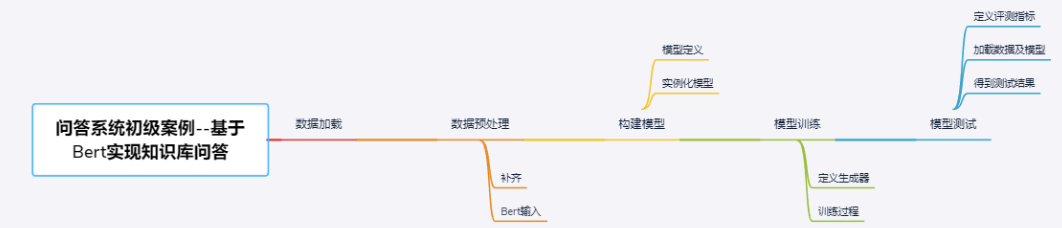

In [1]:
# 统一导入工具包
import pandas as pd
import csv
import transformers
import torch
from transformers import BertPreTrainedModel, BertModel
from torch import nn
import numpy as np
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import transformers as tfs
import math
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import warnings
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
import warnings
warnings.filterwarnings('ignore')

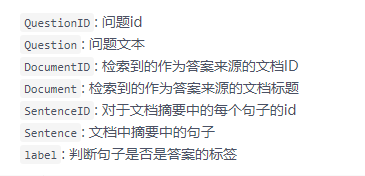

In [2]:
train = pd.read_csv('datasets/raw/WikiQA-train.tsv',encoding="utf-8",sep = '\t')
dev= pd.read_csv('datasets/raw/WikiQA-dev.tsv',encoding="utf-8",sep = '\t')
test=pd.read_csv('datasets/raw/WikiQA-test.tsv',encoding="utf-8",sep = '\t')

In [3]:
train

,QuestionID,Question,DocumentID,DocumentTitle,SentenceID,Sentence,Label
0,Q1,how are glacier caves formed?,D1,Glacier cave,D1-0,A partly submerged glacier cave on Perito More...,0
1,Q1,how are glacier caves formed?,D1,Glacier cave,D1-1,The ice facade is approximately 60 m high,0
2,Q1,how are glacier caves formed?,D1,Glacier cave,D1-2,Ice formations in the Titlis glacier cave,0
3,Q1,how are glacier caves formed?,D1,Glacier cave,D1-3,A glacier cave is a cave formed within the ice...,1
4,Q1,how are glacier caves formed?,D1,Glacier cave,D1-4,"Glacier caves are often called ice caves , but...",0
...,...,...,...,...,...,...,...
20342,Q3043,what is section eight housing,D2807,Section 8 (housing),D2807-8,A tenant who leaves a subsidized project will ...,0
20343,Q3043,what is section eight housing,D2807,Section 8 (housing),D2807-9,The United States Department of Housing and Ur...,0
20344,Q3044,what is the main type of restaurant,D2808,Category:Types of restaurants,D2808-0,Restaurants categorized by type and informatio...,0
20345,Q3046,what is us dollar worth based on,D2810,History of the United States dollar,D2810-0,U.S. Federal Reserve notes in the mid-1990s,0


In [4]:
dev

,QuestionID,Question,DocumentID,DocumentTitle,SentenceID,Sentence,Label
0,Q11,"how big is bmc software in houston, tx",D11,BMC Software,D11-0,"BMC Software, Inc. is an American company spec...",0
1,Q11,"how big is bmc software in houston, tx",D11,BMC Software,D11-1,"Headquartered in Houston , Texas , BMC develop...",0
2,Q11,"how big is bmc software in houston, tx",D11,BMC Software,D11-2,"The name ""BMC"" is taken from the surnames of i...",0
3,Q11,"how big is bmc software in houston, tx",D11,BMC Software,D11-3,"Employing over 6,000, BMC is often credited wi...",1
4,Q11,"how big is bmc software in houston, tx",D11,BMC Software,D11-4,"For 2011, the company recorded an annual reven...",1
...,...,...,...,...,...,...,...
1125,Q2991,what is the name of chris cornell's band?,D2763,Chris Cornell,D2763-2,Cornell's signature prowess as a musician is g...,0
1126,Q2991,what is the name of chris cornell's band?,D2763,Chris Cornell,D2763-3,"He has released three solo studio albums, Euph...",0
1127,Q2991,what is the name of chris cornell's band?,D2763,Chris Cornell,D2763-4,"Cornell was ranked 4th in the list of ""Heavy M...",0
1128,Q2991,what is the name of chris cornell's band?,D2763,Chris Cornell,D2763-5,He performed the theme song to the James Bond ...,0


In [5]:
test

,QuestionID,Question,DocumentID,DocumentTitle,SentenceID,Sentence,Label
0,Q0,HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US,D0,African immigration to the United States,D0-0,African immigration to the United States refer...,0
1,Q0,HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US,D0,African immigration to the United States,D0-1,The term African in the scope of this article ...,0
2,Q0,HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US,D0,African immigration to the United States,D0-2,From the Immigration and Nationality Act of 19...,0
3,Q0,HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US,D0,African immigration to the United States,D0-3,African immigrants in the United States come f...,0
4,Q0,HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US,D0,African immigration to the United States,D0-4,"They include people from different national, l...",0
...,...,...,...,...,...,...,...
2344,Q3012,where is the brisket from,D2780,Brisket,D2780-3,The brisket muscles include the superficial an...,0
2345,Q3012,where is the brisket from,D2780,Brisket,D2780-4,"As cattle do not have collar bones , these mus...",0
2346,Q3012,where is the brisket from,D2780,Brisket,D2780-5,This requires a significant amount of connecti...,0
2347,Q3012,where is the brisket from,D2780,Brisket,D2780-6,According to the Random House Dictionary of th...,0


# 数据预处理

In [24]:
def chuli (data):
    result=[]
    for i in data.values:
        res={}
        res["qu"]=i[1]
        res["an"]=i[5]
        res["label"]=i[6]
        result.append(res)
    return result
train_chuli=chuli(train)
dev_chuli=chuli(dev)
test_chuli=chuli(test)

## 数据加到一个大的列表里
data=[]
label=[]
for i in train_chuli:
    data.append(i)
for i in dev_chuli:
    data.append(i)
for i in test_chuli:
    data.append(i)
    
# 数据分 xy 分开
data_x=[]
data_y=[]
for i in data:
    s=i["qu"]+" ? "+i["an"]
    data_x.append(s)
    data_y.append(i["label"])   
# 一共23826条数据 


# 自己写的数据打乱操作
a= random.sample(range(0, 23826), 23826)
d_x=[]
d_y=[]
for i in a:
    d_x.append(data_x[i])
    d_y.append(data_y[i])
    
    
    

In [41]:
print(len(d_x))
d_x[0:10]

23826


['how many canals in mandibular first molar ? The occlusal surface has four grooves.',
 'what was nixon accused of ? After a protracted series of bitter court battles, the U.S. Supreme Court unanimously ruled that the president had to hand over the tapes to government investigators; he ultimately complied.',
 'when did kurt cobain kill himself ? Following the success of Nevermind, Nirvana was labeled "the flagship band" of Generation X , and Cobain hailed as "the spokesman of a generation".',
 'what part of the bp oil spill affected the water ? Following the explosion and sinking of the Deepwater Horizon oil rig , which claimed 11 lives, a sea-floor oil gusher flowed unabated for 87 days, until it was capped on 15 July 2010.',
 'where does the word woman comes from ? A woman (), pl: women () is a female human .',
 'what state is tahoe in ? Lake Tahoe is the largest alpine lake in North America.',
 'what are the arb medications ? Air Resources Board , California Environmental Protection

In [40]:
d_y[0:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# bert 模型加载

In [42]:
model_class, tokenizer_class, pretrained_weights = (tfs.BertModel, tfs.BertTokenizer,'bert-base-uncased')
#                                                    模型             分词器            词汇表  注意要用英文的词汇表 
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)#定义分词器

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 自定义的数据读取

In [43]:
def read_batch_data(start,batch):
    inputs=x_train[int(start):int(start)+batch]
    labels=y_train[int(start):int(start)+batch]
    return inputs,labels


# 数据分割
x_train,x_test,y_train,y_test = train_test_split(d_x,d_y,test_size=0.2)#  train 数目是：19060

In [44]:
print(len(x_train))
print(len(y_train))

19060
19060


# 模型定义

In [45]:
class BertClassificationModel(nn.Module):
    def __init__(self):
        super(BertClassificationModel, self).__init__()   
        model_class, tokenizer_class, pretrained_weights = (tfs.BertModel, tfs.BertTokenizer, 'bert-base-uncased')         
        self.tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
        self.bert = model_class.from_pretrained(pretrained_weights)
        self.dense = nn.Linear(768,2)  #bert默认的隐藏单元数是768， 输出单元是2，表示二分类
    def forward(self, input_ids,attention_mask):
        bert_output = self.bert(input_ids, attention_mask=attention_mask)
        bert_cls_hidden_state = bert_output[0][:,0,:]       #提取[CLS]对应的隐藏状态
        linear_output = self.dense(bert_cls_hidden_state) 
        return linear_output

In [46]:
epochs = 1
lr = 0.01
bert_classifier_model = BertClassificationModel().to(device)
optimizer = optim.SGD(bert_classifier_model.parameters(), lr=lr, momentum=0.9)
criterion = nn.CrossEntropyLoss()
criterion.to(device)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

CrossEntropyLoss()

In [13]:
for epoch in range(epochs):
    print("第",epoch,"个epoch")
    for i in tqdm(range(1,591,1)):
        optimizer.zero_grad()

        
        inputs,targets=read_batch_data (i,32)
        
        a=[]
        for q in targets:
            a.append(q)
        labels = torch.tensor(a).to(device)  
        
        
        
        batch_tokenized = tokenizer_class.from_pretrained(pretrained_weights).batch_encode_plus(inputs, padding=True, truncation=True, max_length=50)    
        
        input_ids = torch.tensor(batch_tokenized['input_ids']).to(device)  
        attention_mask = torch.tensor(batch_tokenized['attention_mask']).to(device)  
        
        
        outputs = bert_classifier_model(input_ids,attention_mask)
#         print(outputs)
#         print(labels)
        loss = criterion(outputs, labels)  # 交叉熵损失函数 必须是两个tensor进行计算啊
        print(loss)
        loss.backward()
        optimizer.step() 
#         print("第",i,"batch","loss",loss.item())
    
    torch.save(bert_classifier_model.state_dict(), 'trainModel'+str(epoch)+".pth") 

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

第 0 个epoch
tensor(0.3020, device='cuda:0', grad_fn=<NllLossBackward>)


 22%|██████████████████▋                                                                 | 2/9 [00:02<00:08,  1.28s/it]

tensor(0.2135, device='cuda:0', grad_fn=<NllLossBackward>)


 33%|████████████████████████████                                                        | 3/9 [00:03<00:06,  1.09s/it]

tensor(0.1966, device='cuda:0', grad_fn=<NllLossBackward>)


 44%|█████████████████████████████████████▎                                              | 4/9 [00:04<00:05,  1.01s/it]

tensor(0.2172, device='cuda:0', grad_fn=<NllLossBackward>)


 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:05<00:04,  1.08s/it]

tensor(0.2081, device='cuda:0', grad_fn=<NllLossBackward>)


 67%|████████████████████████████████████████████████████████                            | 6/9 [00:06<00:03,  1.12s/it]

tensor(0.1784, device='cuda:0', grad_fn=<NllLossBackward>)


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:07<00:02,  1.16s/it]

tensor(0.1492, device='cuda:0', grad_fn=<NllLossBackward>)


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:09<00:01,  1.18s/it]

tensor(0.1261, device='cuda:0', grad_fn=<NllLossBackward>)


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.17s/it]

tensor(0.0742, device='cuda:0', grad_fn=<NllLossBackward>)


In [47]:
#模型加载：
bert_classifier_mode = BertClassificationModel()
bert_classifier_mode.load_state_dict(torch.load('trainModel0.pth'))
bert_classifier_mode.eval() 
bert_classifier_mode.to(device)  

BertClassificationModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [48]:
def test(): #     一条一条的进行测试：
    y_pred=[]
    y_true=[]
    for i in tqdm(range(593,744,1)):
        with torch.no_grad():
            inputs,targets=read_batch_data (i,32)
            a=[]
            for q in targets:
                a.append(q)
                y_true.append(q)
            labels = torch.tensor(a).to(device)  
            optimizer.zero_grad()
            batch_tokenized = tokenizer_class.from_pretrained(pretrained_weights).batch_encode_plus(inputs, padding=True, truncation=True, max_length=50)    

            input_ids = torch.tensor(batch_tokenized['input_ids']).to(device)  
            attention_mask = torch.tensor(batch_tokenized['attention_mask']).to(device)  
        
            outputs = bert_classifier_model(input_ids,attention_mask)
#             print(outputs)
            # 输出是根绝batch的大小来顶的 batch是32 就输出一个 32行 每行两个的二维矩阵
            for d in outputs:
                outputs=torch.argmax(d)
                y_pred.append(outputs.item())

    return y_true, y_pred

 
y_true, y_pred=test()

#自定义的计算分类的准去率
a=0
for i in range(len(y_true)):
    if y_true[i]==y_pred[i]:
        a=a+1
    else:
        pass
print(a/len(y_true))


Fa=f1_score(y_true, y_pred, average='weighted') 
print(Fa)


100%|████████████████████████████████████████████████████████████████████████████████| 151/151 [03:03<00:00,  1.22s/it]

0.59375
0.6895766352992251
